In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from nn import load_track_data, train_model, look_back, mod, summ, rnn
from keras.models import load_model
from weather_gen import generate_weather, h, w
from pandasql import sqldf
from pandas import read_csv
from time import time
from math import pi

os.chdir("C:/Users/adame/OneDrive/Bureau/IRP doc")

In [2]:
look_back

30

In [3]:
def dist(lon1,lon2,lat1,lat2,alt1,alt2): # Function to calculate the distance in km based on coordinates and altitudes
    a = 2*pi/360 # Conversion from degree to radian
    
    #Trigonometry formula for the distance in km regardless of altitude
    d_flat = 6371 * np.arccos((np.sin(a*lat1) * np.sin(a*lat2)) + np.cos(a*lat1) * np.cos(a*lat2) * np.cos(a*lon2 - a*lon1))
    
    d_h = alt1-alt2 # Vertical distance (in km)
    return(np.sqrt(d_flat * d_flat + d_h * d_h)) # Pythagoras theorem for the final distance

def indexes(trajec_list):
    # Similarity index gathering similar trajectories
    # The differentiation is made on whether the latitude is within certain ranges
    
    index_list = []

    for traj in trajec_list:
        if traj[40][2] > 36.8:
            index_list.append(0)
        elif traj[40][2] > 34.5:
            index_list.append(1)
        else:
            index_list.append(2)

    return index_list

def is_above_threshold(d_coord, d_speed, th_coord = 0.5, th_speed = 0.05):
    return(d_coord > th_coord or d_speed > th_speed)

In [4]:
tracks = read_csv("C:/Users/adame/Documents/DeepTPmaster/src/DATA/flight_tracks.csv") # Real flight tracks (HOU to BOS)

In [5]:
# Get all distinct flight IDs
IDs = list(sqldf("SELECT DISTINCT FID FROM tracks WHERE FID IS NOT NULL")['FID'])
n_ids = len(IDs)

In [6]:
# List distinct trajectories
trajec_list = []
for ID in IDs:
    trajec_list.append(np.array(sqldf("SELECT FID AS ID, Lon, Lat, Alt, Speed FROM tracks WHERE FID = " + str(ID) )))

trajec_list = np.array(trajec_list)

# Number of columns without the ID
n_feat = trajec_list[0].shape[1]-1

In [7]:
# Generate training data from trajectory list
# trajectories are cut into segments of length "look_back", normalized (mu, sigma are mean and stddev) and shuffled
X_train, y_train, X_val, y_val, X_test, y_test, mu, sigma = load_track_data(trajec_list)

index_list = indexes(trajec_list)

In [8]:
h,w

(25, 25)

In [9]:
wcc, wind_v, wind_h = [], [], []

# Generate as many different datasets as there are different indexes
for _ in range(3):
    generate_weather(h,w)
    wcc.append(np.load("data_own/wcc.npy"))
    wind_v.append(np.load("data_own/wind_vert.npy"))
    wind_h.append(np.load("data_own/wind_horiz.npy"))
    os.remove("data_own/wcc.npy")
    os.remove("data_own/wind_vert.npy")
    os.remove("data_own/wind_horiz.npy")

# Create weather datasets
wcc_train, wcc_val, wcc_test = [],[],[]
wind_v_train, wind_v_val, wind_v_test = [],[],[]
wind_h_train, wind_h_val, wind_h_test = [],[],[]

for u in X_train:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_train.append(wcc[index_list[p]])
            wind_v_train.append(wind_v[index_list[p]])
            wind_h_train.append(wind_h[index_list[p]])

for u in X_val:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_val.append(wcc[index_list[p]])
            wind_v_val.append(wind_v[index_list[p]])
            wind_h_val.append(wind_h[index_list[p]])

for u in X_test:
    idd = (u[0]*sigma+mu)[0]
    for p in range(len(IDs)):
        if IDs[p]==idd:
            wcc_test.append(wcc[index_list[p]])
            wind_v_test.append(wind_v[index_list[p]])
            wind_h_test.append(wind_h[index_list[p]])

wcc_train, wcc_val, wcc_test = np.array(wcc_train).reshape((-1,h,w,1)), np.array(wcc_val).reshape((-1,h,w,1)), np.array(wcc_test).reshape((-1,h,w,1))
wind_v_train, wind_v_val, wind_v_test = np.array(wind_v_train).reshape((-1,h,w,1)), np.array(wind_v_val).reshape((-1,h,w,1)), np.array(wind_v_test).reshape((-1,h,w,1))
wind_h_train, wind_h_val, wind_h_test = np.array(wind_h_train).reshape((-1,h,w,1)), np.array(wind_h_val).reshape((-1,h,w,1)), np.array(wind_h_test).reshape((-1,h,w,1)) 

In [10]:
# Remove IDs from features and constants
X_train = X_train[:,:,1:n_feat+1]
X_val = X_val[:,:,1:n_feat+1]
X_test = X_test[:,:,1:n_feat+1]

y_train = y_train[:,1:n_feat+1]
y_val = y_val[:,1:n_feat+1]
y_test = y_test[:,1:n_feat+1]

mu = mu[1:n_feat+1]
sigma = sigma[1:n_feat+1]

In [11]:
# Initialize the model
epochs = 50
batch_size = 126

model = mod(n_feat = n_feat)
#model = load_model('models/model')

# Compile
summ(model)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 23, 23, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 11, 11, 16)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [12]:
t=time()
hist = model.fit(
	x = [wind_v_train, X_train], y = y_train,
	validation_data=([wind_v_val, X_val], y_val),
	epochs = epochs, batch_size = batch_size)

Epoch 1/50
72/72 [==============================] - 36s 186ms/step - loss: 1.0346 - val_loss: 0.3015
Epoch 2/50
72/72 [==============================] - 13s 177ms/step - loss: 0.2848 - val_loss: 0.2803
Epoch 3/50
72/72 [==============================] - 14s 195ms/step - loss: 0.2648 - val_loss: 0.2362
Epoch 4/50
72/72 [==============================] - 13s 175ms/step - loss: 0.2328 - val_loss: 0.2236
Epoch 5/50
72/72 [==============================] - 13s 175ms/step - loss: 0.2306 - val_loss: 0.2211
Epoch 6/50
72/72 [==============================] - 15s 205ms/step - loss: 0.2029 - val_loss: 0.2193
Epoch 7/50
72/72 [==============================] - 13s 178ms/step - loss: 0.2150 - val_loss: 0.2096
Epoch 8/50
72/72 [==============================] - 14s 194ms/step - loss: 0.1990 - val_loss: 0.2100
Epoch 9/50
72/72 [==============================] - 13s 177ms/step - loss: 0.2003 - val_loss: 0.2120
Epoch 10/50
72/72 [==============================] - 13s 176ms/step - loss: 0.2039 - val_lo

In [13]:
print("training time: ",time()-t)

training time:  626.3758528232574


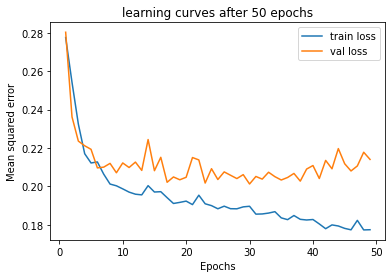

In [15]:
s = 1
plt.plot(range(s,epochs), hist.history['loss'][s:], label = "train loss")
plt.plot(range(s,epochs), hist.history['val_loss'][s:], label = "val loss")
plt.legend()
plt.title("learning curves after "+str(epochs)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [17]:
hist2 = model.fit(
	x = [wind_v_train, X_train], y = y_train,
	validation_data=([wind_v_val, X_val], y_val),
	epochs = epochs, batch_size = batch_size)

Epoch 1/30
182/182 [==============================] - 9s 49ms/step - loss: 0.2745 - val_loss: 0.2731
Epoch 2/30
182/182 [==============================] - 7s 39ms/step - loss: 0.2667 - val_loss: 0.2766
Epoch 3/30
182/182 [==============================] - 8s 42ms/step - loss: 0.2607 - val_loss: 0.2577
Epoch 4/30
182/182 [==============================] - 7s 39ms/step - loss: 0.2555 - val_loss: 0.2558
Epoch 5/30
182/182 [==============================] - 7s 36ms/step - loss: 0.2543 - val_loss: 0.2599
Epoch 6/30
182/182 [==============================] - 6s 35ms/step - loss: 0.2503 - val_loss: 0.2503
Epoch 7/30
182/182 [==============================] - 7s 37ms/step - loss: 0.2488 - val_loss: 0.2617
Epoch 8/30
182/182 [==============================] - 6s 34ms/step - loss: 0.2420 - val_loss: 0.2479
Epoch 9/30
182/182 [==============================] - 6s 35ms/step - loss: 0.2431 - val_loss: 0.2730
Epoch 10/30
182/182 [==============================] - 7s 39ms/step - loss: 0.2403 - val_lo

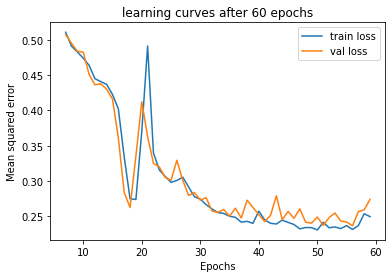

In [20]:
plt.plot(range(s,2*epochs), (list(hist.history['loss'])+list(hist2.history['loss']))[s:], label = "train loss")
plt.plot(range(s,2*epochs), (list(hist.history['val_loss'])+list(hist2.history['val_loss']))[s:], label = "val loss")
plt.legend()
plt.title("learning curves after "+str(2*epochs)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [33]:
hist3 = model.fit(
	x = [wind_v_train, X_train], y = y_train,
	validation_data=([wind_v_val, X_val], y_val),
	epochs = 50, batch_size = batch_size)

Epoch 1/50
11/11 [==============================] - 3s 268ms/step - loss: 0.1592 - val_loss: 0.2074
Epoch 2/50
11/11 [==============================] - 3s 267ms/step - loss: 0.1629 - val_loss: 0.2005
Epoch 3/50
11/11 [==============================] - 3s 271ms/step - loss: 0.1614 - val_loss: 0.2032
Epoch 4/50
11/11 [==============================] - 3s 271ms/step - loss: 0.1601 - val_loss: 0.2005
Epoch 5/50
11/11 [==============================] - 3s 274ms/step - loss: 0.1593 - val_loss: 0.2001
Epoch 6/50
11/11 [==============================] - 3s 278ms/step - loss: 0.1600 - val_loss: 0.1985
Epoch 7/50
11/11 [==============================] - 3s 278ms/step - loss: 0.1578 - val_loss: 0.2049
Epoch 8/50
11/11 [==============================] - 3s 277ms/step - loss: 0.1585 - val_loss: 0.2004
Epoch 9/50
11/11 [==============================] - 3s 268ms/step - loss: 0.1571 - val_loss: 0.2005
Epoch 10/50
11/11 [==============================] - 3s 273ms/step - loss: 0.1580 - val_loss: 0.1987

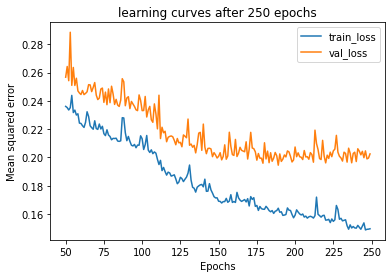

In [34]:
plt.plot(range(s,250), (list(hist.history['loss'])+list(hist2.history['loss'])+list(hist3.history['loss']))[s:], label = "train_loss")
plt.plot(range(s,250), (list(hist.history['val_loss'])+list(hist2.history['val_loss'])+list(hist3.history['val_loss']))[s:], label = "val_loss")
plt.legend()
plt.title("learning curves after "+str(250)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [27]:
X_train.shape

(9069, 30, 4)

In [ ]:
model.save("models/model")
print("Saved after "+str(2*epochs)+" epochs")

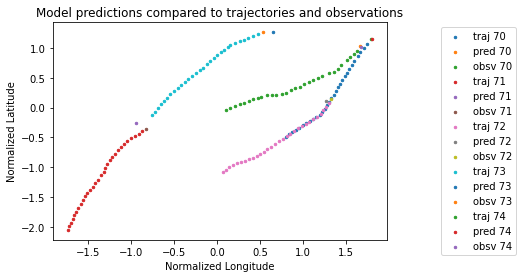

In [30]:
# Plot a couple trajectories, observation and prediction

u = model.predict([wind_v_test, X_test])
for p in range(70,75):
    plt.scatter(X_test[p][:,0],X_test[p][:,1], label = "traj "+str(p), s=6)
    plt.scatter(u[p][0],u[p][1], label = "pred " + str(p), s=6)
    plt.scatter(y_test[p][0], y_test[p][1], label = "obsv " + str(p), s=6)

plt.legend(bbox_to_anchor=(1.4, 1))
plt.title("Model predictions compared to trajectories and observations")
plt.xlabel("Normalized Longitude")
plt.ylabel("Normalized Latitude")
plt.show()

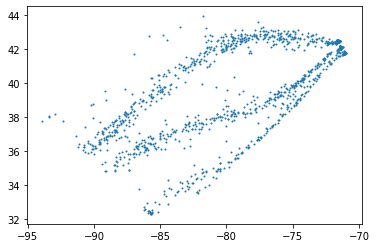

In [74]:
u.shape
plt.scatter(u[:,0]*sigma[0] + mu[0], u[:,1]*sigma[1] + mu[1],s=1)

In [15]:
# Create FL framework
## Partition data among aircrafts

n_acs = 4
acs = list(range(n_acs))

n_train_data_ac = int(X_train.shape[0]/n_acs)

fl_X_train_traj = [0 for _ in range(n_acs)]
fl_X_train_w = [0 for _ in range(n_acs)]
fl_y_train = [0 for _ in range(n_acs)]

for i in range(n_acs-1):
    fl_X_train_traj[i] = X_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    fl_X_train_w[i] = wind_v_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    fl_y_train[i] = y_train[i*n_train_data_ac:(i+1)*n_train_data_ac]
    
fl_X_train_traj[n_acs-1] = X_train[(n_acs-1)*n_train_data_ac:]
fl_X_train_w[n_acs-1] = wind_v_train[(n_acs-1)*n_train_data_ac:]
fl_y_train[n_acs-1] = y_train[(n_acs-1)*n_train_data_ac:]


In [22]:
############# Training phase #############

# Training using FL

from keras.losses import MeanSquaredError
t=time()
n_cycles = 5

epochs = 15
batch_size = 256

weights_agg = []
hists = [[] for _ in range(n_acs)]

models = [mod(n_feat) for _ in range(n_acs)]
model_agg = mod(n_feat)

for p in range(n_acs):
    summ(models[p])

summ(model_agg)

losses = []
mse = MeanSquaredError()

for p in range(n_cycles):
    print("Cycle", p+1)
    
    if p==0:
        weights = [0 for _ in range(n_acs)]
    
    for ac in range(n_acs):
        print("Aircraft",ac+1)
        
        if p > 0:
            models[ac].set_weights(weights_agg)
        
        hists[ac].append(models[ac].fit(x = [fl_X_train_w[ac], fl_X_train_traj[ac]], y = fl_y_train[ac],
            epochs = epochs, batch_size = batch_size, verbose=2))
        weights[ac] = models[ac].get_weights()
    
    if p==0:
        n_arrays = len(weights[0])
        for layer in range(n_arrays):
            weights_agg.append(np.zeros(np.shape(weights[0][layer])))

    for layer in range(n_arrays):
        for ac in range(n_acs):
            weights_agg[layer] += weights[ac][layer]
        weights_agg[layer] /= n_acs
    
    model_agg.set_weights(weights_agg)
    agg_pred = model_agg.predict([wind_v_test, X_test])
    
    losses.append(mse(y_test, agg_pred).numpy())
    
    if p != n_cycles-1:
        for ac in range(n_acs):
            for layer in range(n_arrays):
                weights[ac][layer] = weights_agg[layer]
            
    print(mse(y_test, agg_pred).numpy())

fl_penalty = n_cycles * n_acs * 2 * sum([np.size(u) for u in weights_agg])
classic_penalty = np.size(X_train) + n_acs * sum([np.size(u) for u in weights_agg])
print("time:",time()-t)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 25, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 23, 23, 16)   160         input_23[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 11, 11, 16)   0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 9, 9, 16)     2320        max_pooling2d_22[0][0]           
___________________________________________________________________________________________

9/9 - 6s - loss: 1359.9086
Epoch 2/15
9/9 - 1s - loss: 227.7077
Epoch 3/15
9/9 - 1s - loss: 45.4825
Epoch 4/15
9/9 - 1s - loss: 12.1571
Epoch 5/15
9/9 - 1s - loss: 6.3941
Epoch 6/15
9/9 - 1s - loss: 3.6966
Epoch 7/15
9/9 - 1s - loss: 3.3194
Epoch 8/15
9/9 - 1s - loss: 2.3421
Epoch 9/15
9/9 - 1s - loss: 2.1293
Epoch 10/15
9/9 - 1s - loss: 2.0364
Epoch 11/15
9/9 - 1s - loss: 2.0406
Epoch 12/15
9/9 - 1s - loss: 2.0334
Epoch 13/15
9/9 - 1s - loss: 2.0166
Epoch 14/15
9/9 - 1s - loss: 2.0634
Epoch 15/15
9/9 - 1s - loss: 1.9973
Aircraft 2
Epoch 1/15
9/9 - 5s - loss: 161.2986
Epoch 2/15
9/9 - 1s - loss: 30.6348
Epoch 3/15


KeyboardInterrupt: 

In [28]:

(26200 + 42000 + 9680) / 86154

0.9039626714952295

In [23]:
mod_size = sum([np.size(u) for u in weights[0]])

In [24]:
data_size = X_train.size

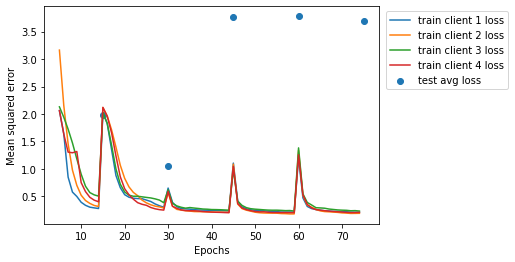

In [47]:
s = 5
for ac in range(n_acs):
    plt.plot(range(s,n_cycles*epochs), (np.array([hists[ac][p].history['loss'] for p in range(n_cycles)]).reshape((-1)))[s:], label = "train client "+str(ac+1)+" loss")
plt.scatter([(p+1)*epochs for p in range(n_cycles)], losses, label = "test avg loss")
plt.legend(bbox_to_anchor=(1.4, 1))
#plt.title("learning curves after "+str(epochs)+" epochs")
plt.xlabel("Epochs")
plt.ylabel("Mean squared error")
plt.show()

In [42]:
print("##### PARAMETERS #####\n")
print("FL cycles:", n_cycles)
print("No of aircrafts:",n_acs)
print("Epochs:",epochs)
print("Batch size:", batch_size)
print("Delay parameter:", look_back)
print("Observations per aircraft:",fl_X_train_traj[0].shape[0])

print("\nFL penalty:",fl_penalty,"\nclassic penalty:", classic_penalty)
print("Aggregated model errors over the cycles:\n", losses)
print("Ratio:",fl_penalty/classic_penalty)

##### PARAMETERS #####

FL cycles: 5
No of aircrafts: 4
Epochs: 15
Batch size: 256
Delay parameter: 30
Observations per aircraft: 2267

FL penalty: 3446160 
classic penalty: 1088280
Aggregated model errors over the cycles:
 [1.9849722, 1.049482, 3.7724037, 3.7788966, 3.6849966]
Ratio: 3.1666115337964493


689232.0

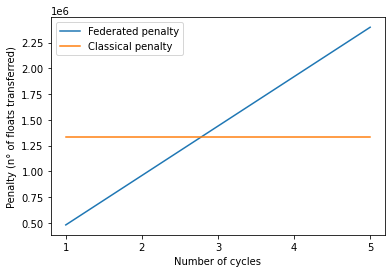

In [25]:
n_cycles = 5

x = np.linspace(1,n_cycles,n_cycles)
y_fl = 2*n_acs*mod_size*x
y_cl = [n_acs*mod_size + data_size for _ in range(n_cycles)]
plt.plot(x,y_fl, label = "Federated penalty")
plt.plot(x,y_cl, label = "Classical penalty")
plt.xlabel("Number of cycles")
plt.ylabel("Penalty (n° of floats transferred)")
plt.xticks(range(1,n_cycles+1))
plt.legend()
plt.show()

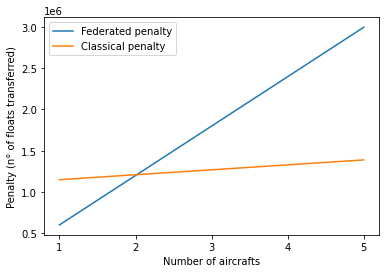

In [26]:
n_acs = 5

x = np.linspace(1,n_acs,n_acs)
y_fl = 2*x*mod_size*n_cycles
y_cl = mod_size*x + data_size
plt.plot(x,y_fl, label = "Federated penalty")
plt.plot(x,y_cl, label = "Classical penalty")
plt.xlabel("Number of aircrafts")
plt.ylabel("Penalty (n° of floats transferred)")
plt.xticks(range(1,n_acs+1))
plt.legend()
plt.show()

In [27]:
3446160/4

861540.0

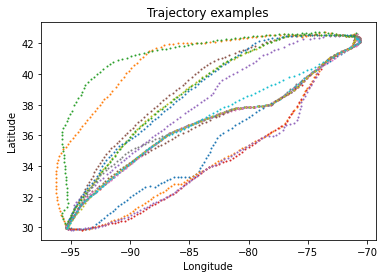

In [100]:
traj_sample = []

for p in range(20):
    traj_sample.append(trajec_list[p][:,1:])
    plt.scatter(trajec_list[p][:,1], trajec_list[p][:,2], s=1)

plt.title("Trajectory examples")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [65]:
############# Operational phase #############

penalties_n, penalties_s = [], []

traj_sample = []

for p in range(10):
    traj_sample.append(trajec_list[p][:,1:])

traj_sample = np.array(traj_sample)

for j in range(traj_sample.shape[0]):
    print(j)
    traj = traj_sample[j]
    n = traj.shape[0]
    pen_normal = 0
    pen_syst = 0
    coords_actual, coords_pred = [], []

    wind = (wind_v[index_list[j]]).reshape(1,h,w,1)
    
    for i in range(n):
        pen_normal += n_feat

        if i < look_back:
            pen_syst += n_feat
            coords_actual.append(traj[i])
            coords_pred.append(traj[i])

        else:
            last_n = coords_pred[i-look_back : i]
            pred = model.predict( [wind,np.array(last_n).reshape((1,look_back,4))] )
            pred = pred.reshape((4)) * sigma + mu
            d_coord = dist(pred[0], traj[i][0], pred[1], traj[i][1], pred[2]/1000, traj[i][2]/1000)
            d_speed = np.absolute(pred[3] - traj[i][3])
            
            if i==30:
                print("pred \n", pred)
                print("traj_i \n", traj[i])

            if is_above_threshold(d_coord, d_speed, th_coord = 200, th_speed = 5):
                pen_syst += n_feat
                coords_actual.append(traj[i])
                coords_pred.append(traj[i])

            else:
                coords_actual.append(traj[i])
                coords_pred.append(pred)

    penalties_n.append(pen_normal)
    penalties_s.append(pen_syst)

print(penalties_n)
print(penalties_s)


0
pred 
 [-8.57465659e+01  3.47205738e+01  4.23069836e+02  1.30243721e-01]
traj_i 
 [-8.79000000e+01  3.26500000e+01  3.50000000e+02  1.22889715e-01]
1
pred 
 [-8.64085587e+01  3.61643812e+01  4.13084188e+02  1.27390468e-01]
traj_i 
 [-9.44000000e+01  3.62500000e+01  3.50000000e+02  1.15939527e-01]
2
pred 
 [-8.67825945e+01  3.60158850e+01  4.12421603e+02  1.27025183e-01]
traj_i 
 [-9.54833333e+01  3.67000000e+01  3.70000000e+02  1.49163639e-01]
3
pred 
 [-8.70576363e+01  3.47599598e+01  4.17252449e+02  1.30173849e-01]
traj_i 
 [-8.92833333e+01  3.46166667e+01  3.70000000e+02  1.16870248e-01]
4
pred 
 [-8.63178624e+01  3.52906612e+01  4.20222540e+02  1.28797926e-01]
traj_i 
 [-8.95666667e+01  3.50000000e+01  3.50000000e+02  1.16503525e-01]
5
pred 
 [-8.67693301e+01  3.60182874e+01  4.12652731e+02  1.27136711e-01]
traj_i 
 [-9.06833333e+01  3.58333333e+01  3.50000000e+02  1.26028724e-01]
6
pred 
 [-8.70369188e+01  3.47933532e+01  4.17756098e+02  1.30216689e-01]
traj_i 
 [-8.95000000e+01

In [66]:
print([1-penalties_s[k]/penalties_n[k] for k in range(10)])

[0.07070707070707072, 0.0, 0.0, 0.11340206185567014, 0.061224489795918324, 0.0, 0.09708737864077666, 0.10999999999999999, 0.020000000000000018, 0.09183673469387754]


In [23]:
dist(-87.0744, -89.133, 34.741, 34.716, 0.417, 0.35)

188.14602072466232

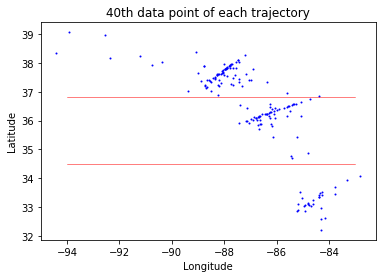

In [11]:
for p in trajec_list:
    plt.scatter(p[40][1], p[40][2], c="blue", s=1)

plt.plot(range(-94,-82), [36.8 for _ in range(-94,-82)], c = "red", linewidth = 0.5)
plt.plot(range(-94,-82), [34.5 for _ in range(-94,-82)], c = "red", linewidth = 0.5)
plt.title("40th data point of each trajectory")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()